# USEFUL FUNCTIONS

In [53]:
import pandas as pd


def strip_date(df):
    df['Month'] = df['Date'].dt.month
    df = df.drop(columns=['Date'])
    return df


def split_by_attr(attr: str, data_train: pd.DataFrame):
    X_data_train = data_train[[col for col in data_train.columns if col != attr]]
    y_data_train = data_train[attr]
    return X_data_train, y_data_train


def numerize(data: pd.Series):
    unique_value = data.unique()
    string_to_int = {value: i for i, value in enumerate(unique_value)}
    data = data.map(string_to_int)
    return data

def drop_all_except(df_expanded, *exceptions):
    return df_expanded.drop([col for col in df_expanded.columns if col not in exceptions], axis=1)

# ADDITIONAL INDEX DATA

In [54]:
data_income_tax: pd.DataFrame = pd.read_csv("Dataset/income_tax.csv")
data_income_tax.rename(columns={"DATE": "Date"}, inplace=True)
data_income_tax["Date"] = pd.to_datetime(data_income_tax["Date"], format='%Y-%m-%d')
data_income_tax = data_income_tax[data_income_tax["Date"].dt.year >= 2005]
new_rows = []
for _, row in data_income_tax.iterrows():
    year = row['Date'].year
    day = row['Date'].day
    original_month = row['Date'].month
    for month in range(1, 13):
        new_row = row.copy()
        new_row['Date'] = pd.Timestamp(year=year, month=month, day=day)
        new_rows.append(new_row)
df_expanded = pd.DataFrame(new_rows)
df_expanded.sort_values(by='Date', inplace=True)
df_expanded["Year-Month"] = df_expanded["Date"].dt.to_period('M')
data_income_tax = drop_all_except(df_expanded, "Year-Month", "Date", "IITTRHB")

In [55]:
data_cfnfci = pd.read_csv("Dataset/cfnfci.csv")
data_cfnfci.rename(columns={"Friday_of_Week": "Date"}, inplace=True)
data_cfnfci["Date"] = pd.to_datetime(data_cfnfci["Date"], format='%m/%d/%Y')
data_cfnfci = data_cfnfci[data_cfnfci["Date"].dt.year >= 2005]
data_cfnfci["Year-Month"] = data_cfnfci["Date"].dt.to_period('M')
data_cfnfci = data_cfnfci.groupby(data_cfnfci['Year-Month']).mean()
data_cfnfci = drop_all_except(data_cfnfci, "NFCI", "Date", "Year-Month")

In [56]:
data_cfnai_series = pd.read_csv("Dataset/CFNAI.csv")
data_cfnai_series["Date"] = pd.to_datetime(data_cfnai_series["Date"], format='%Y/%m')
data_cfnai_series = data_cfnai_series[data_cfnai_series["Date"].dt.year >= 2005]
data_cfnai_series["Year-Month"] = data_cfnai_series["Date"].dt.to_period('M')
data_cfnai_series = drop_all_except(data_cfnai_series, "CFNAI", "Date", "Year-Month")

# TRAIN DATA

In [57]:
#GETTING TRAIN DATA
data_train = pd.read_csv("Dataset/train_fixed.csv", sep=',')
data_train["Date"] = pd.to_datetime(data_train["Date"], format='%d/%m/%Y')
data_train[["Sector", "Rating"]] = data_train[["Sector", "Rating"]].astype(str)

In [58]:
#CONVERTING TRAIN DATA
data_train["Rating"] = numerize(data_train["Rating"])
data_train["Year-Month"] = data_train["Date"].dt.to_period('M')
data_train = strip_date(data_train)

In [59]:
data_train = pd.get_dummies(data_train, columns=["Month"], prefix=["Month"])
data_train = pd.get_dummies(data_train, columns=['Sector'], prefix='Sector')

In [60]:
data_train = pd.merge(data_train, data_income_tax, on="Year-Month", how='inner')
data_train = pd.merge(data_train, data_cfnfci, on='Year-Month', how='inner')
data_train = pd.merge(data_train, data_cfnai_series.drop("Date", axis=1), on='Year-Month', how='inner')

data_train = data_train.drop(["Date_x", "Date_y"], axis=1)
data_train = data_train.drop(["Year-Month"], axis=1)

X, y = split_by_attr("Rating", data_train)

In [61]:
X

,Liquidity1,Liquidity2,Liquidity3,Liquidity4,Profitability1,Profitability2,Profitability3,Profitability4,Profitability5,Profitability6,...,Sector_Energy,Sector_Finance,Sector_Health Care,Sector_Miscellaneous,Sector_Public Utilities,Sector_Technology,Sector_Transportation,IITTRHB,NFCI,CFNAI
0,0.818622,0.505423,0.071419,16.428318,0.078944,0.125334,1.000000,0.125334,0.093049,0.181247,...,True,False,False,False,False,False,False,39.6,-0.665,0.26
1,1.053883,0.238644,0.024910,85.303030,0.115982,0.146534,1.000000,0.163221,0.046923,0.119596,...,False,True,False,False,False,False,False,39.6,-0.665,0.26
2,1.706867,1.211122,0.211406,51.204800,0.012760,0.011388,0.114641,0.029564,0.011526,0.013264,...,False,False,False,False,False,False,False,39.6,-0.665,0.26
3,2.772056,1.332744,0.668038,38.391946,-0.042448,-0.080318,0.074197,-0.051503,-0.053794,-0.127490,...,False,False,False,False,False,False,False,39.6,-0.665,0.26
4,1.992424,1.346970,0.897727,38.329201,0.095449,0.102532,0.467505,0.183992,0.078686,0.178300,...,False,False,False,False,False,True,False,39.6,-0.665,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,0.882592,0.556147,0.144622,36.783384,0.094578,0.189980,1.000000,0.189980,0.145030,0.500709,...,True,False,False,False,False,False,False,35.0,-0.625,0.22
1618,0.608147,0.520368,0.379111,39.934435,0.210656,0.282949,0.810869,0.283239,0.077846,0.172905,...,False,False,False,False,True,False,False,35.0,-0.042,0.26
1619,1.138071,0.774901,0.263484,55.178881,0.117551,0.185655,1.000000,0.188932,0.066649,0.132171,...,False,False,False,False,False,False,False,35.0,-0.042,0.26
1620,1.339710,1.082319,0.234783,45.322651,0.121564,0.017165,1.000000,0.068876,0.131647,0.023321,...,False,False,True,False,False,False,False,35.0,-0.320,-0.16


In [62]:
y

0       0
1       0
2       3
3       2
4       3
       ..
1617    0
1618    2
1619    0
1620    3
1621    1
Name: Rating, Length: 1622, dtype: int64

# TEST DATA

In [63]:
#GETTING TEST DATA
X_test = pd.read_csv("Dataset/test_fixed.csv", sep=',')
X_test["Date"] = pd.to_datetime(X_test["Date"], format='%d/%m/%Y')
X_test["Sector"] = X_test["Sector"].astype(str)

In [64]:
X_test["Year-Month"] = X_test["Date"].dt.to_period('M')
X_test = strip_date(X_test)

In [65]:
X_test = pd.get_dummies(X_test, columns=["Month"], prefix=["Month"])
X_test = pd.get_dummies(X_test, columns=['Sector'], prefix='Sector')

In [66]:
X_test = pd.merge(X_test, data_income_tax, on="Year-Month", how='inner')
X_test = pd.merge(X_test, data_cfnfci, on='Year-Month', how='inner')
X_test = pd.merge(X_test, data_cfnai_series.drop("Date", axis=1), on='Year-Month', how='inner')

In [67]:
X_test = X_test.drop(["Date_x", "Date_y"], axis=1)
X_test = X_test.drop(["Year-Month"], axis=1)

In [68]:
X_test

,Liquidity1,Liquidity2,Liquidity3,Liquidity4,Profitability1,Profitability2,Profitability3,Profitability4,Profitability5,Profitability6,...,Sector_Energy,Sector_Finance,Sector_Health Care,Sector_Miscellaneous,Sector_Public Utilities,Sector_Technology,Sector_Transportation,IITTRHB,NFCI,CFNAI
0,1.007819,0.919635,0.115552,43.759294,0.081010,0.123296,1.000000,0.180143,0.025713,0.044129,...,False,False,False,False,True,False,False,39.6,-0.4800,-0.36
1,0.875910,0.807503,0.008010,35.582194,0.111379,0.179259,1.000000,0.221773,0.028973,0.051683,...,False,False,False,False,True,False,False,39.6,-0.4800,-0.36
2,0.915910,0.415194,0.139513,23.224008,0.103313,0.155461,1.000000,0.206461,0.026650,0.043997,...,False,False,False,False,True,False,False,39.6,-0.4800,-0.36
3,1.673677,1.211022,0.134336,49.310293,0.048840,0.090776,1.000000,0.090776,0.065020,0.145328,...,False,False,True,False,False,False,False,39.6,-0.4800,-0.36
4,0.672999,0.629579,0.223881,32.284942,-1.150501,-1.496239,1.000000,-1.482216,-0.846056,-1.396870,...,True,False,False,False,False,False,False,39.6,-0.4800,-0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,1.283474,0.734399,0.045469,133.650603,0.246199,0.249148,0.007556,0.466138,0.035901,0.039736,...,True,False,False,False,False,False,False,35.0,-0.0160,-0.26
402,1.939021,1.097348,0.405797,45.544105,0.102394,0.147994,0.254266,0.148548,0.158382,0.333417,...,True,False,False,False,False,False,False,35.0,-0.0160,-0.26
403,2.063355,0.510799,0.260619,0.000000,0.094009,0.133847,0.122096,0.136606,0.131286,0.225937,...,False,False,False,False,False,False,False,35.0,1.4075,-1.58
404,2.760287,2.499718,1.138881,67.913649,0.239936,0.320336,0.942255,0.337797,0.116230,0.192289,...,False,False,False,False,False,True,False,35.0,-0.3975,0.05


# PREPROCESSING AND ANALYSIS

In [69]:
class_counts = y.value_counts()
class_percentage = class_counts / len(y) * 100 
print(class_percentage)

Rating
1    33.230580
0    24.352651
2    23.921085
3    18.495684
Name: count, dtype: float64


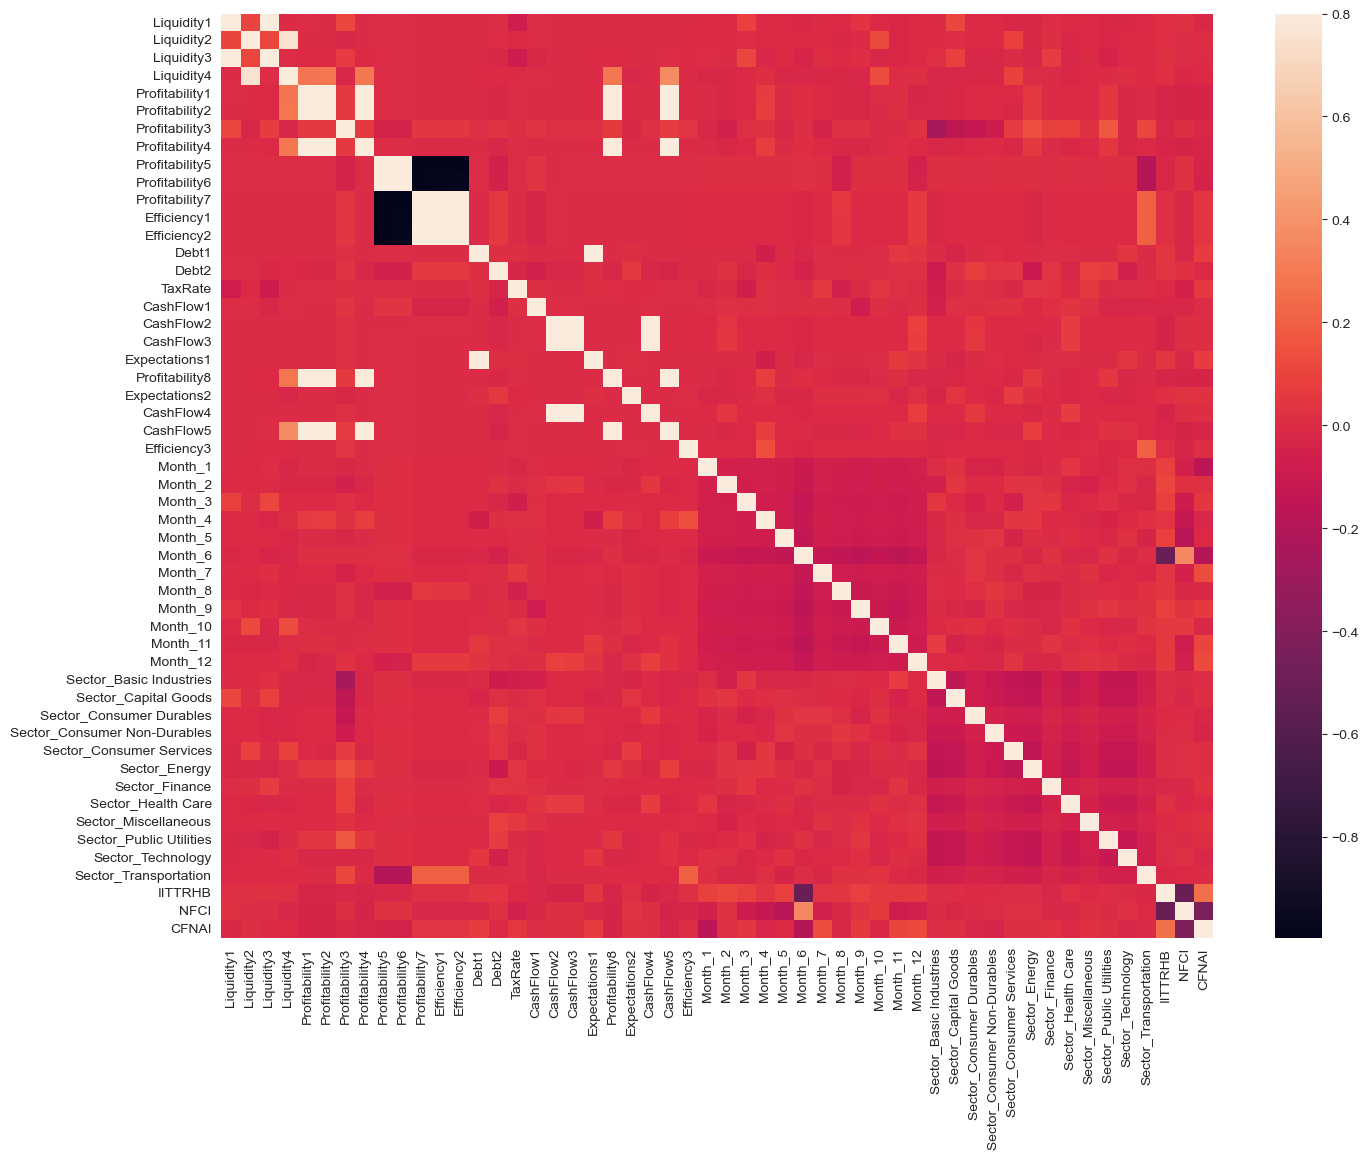

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

correlation_matrix = X.corr()
fig = plt.figure(figsize = (16, 12))
sns.heatmap(correlation_matrix, vmax = 0.8)
plt.show()

# conclusion: very low linear correlation between features

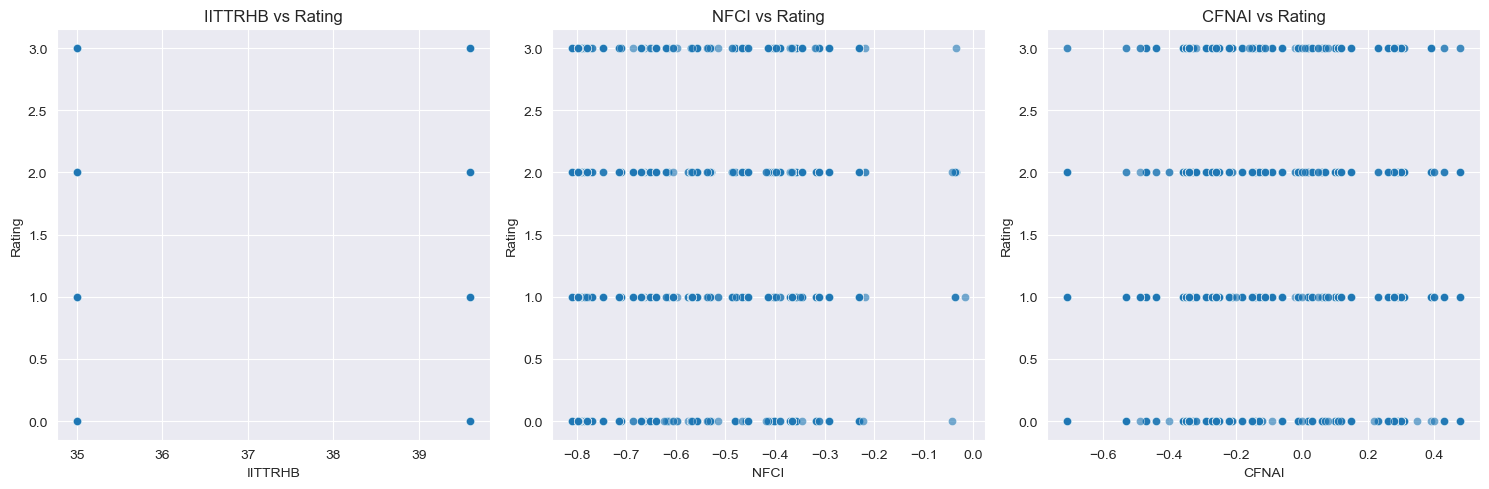

In [71]:
merged_data = X.copy()
merged_data["Rating"] = y.copy()

columns_of_interest = ['IITTRHB', 'NFCI', 'CFNAI', 'Rating']
data_of_interest = merged_data[columns_of_interest]

plt.figure(figsize=(15, 5))

for i, column in enumerate(['IITTRHB', 'NFCI', 'CFNAI'], 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=data_of_interest, x=column, y='Rating', alpha=0.6)
    plt.title(f'{column} vs Rating')
    plt.xlabel(column)
    plt.ylabel('Rating')

plt.tight_layout()
plt.show()

# TRAIN TEST SPLIT

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# RANDOM FOREST

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from model_library import loss_fn

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_val)

cm_rf = confusion_matrix(y_val, rf_predictions)
loss_rf = loss_fn(cm_rf)

print("Random Forest Loss:", loss_rf)
print("Random Forest Classifier Performance:")
print("Accuracy:", accuracy_score(y_val, rf_predictions))
print(classification_report(y_val, rf_predictions))


Random Forest Loss: 288
Random Forest Classifier Performance:
Accuracy: 0.556923076923077
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        79
           1       0.50      0.67      0.57       108
           2       0.49      0.36      0.41        78
           3       0.65      0.53      0.59        60

    accuracy                           0.56       325
   macro avg       0.57      0.54      0.55       325
weighted avg       0.56      0.56      0.55       325


# SVC

In [74]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

svc_classifier = SVC(kernel='rbf', random_state=42)

svc_classifier.fit(X_train_scaled, y_train)

svc_predictions = svc_classifier.predict(X_val_scaled)

cm_svc = confusion_matrix(y_val, svc_predictions)
loss_svc = loss_fn(cm_svc)

print("SVC Loss:", loss_svc)
print("Support Vector Classifier Performance:")
print("Accuracy:", accuracy_score(y_val, svc_predictions))
print(classification_report(y_val, svc_predictions))

SVC Loss: 450
Support Vector Classifier Performance:
Accuracy: 0.3723076923076923
              precision    recall  f1-score   support

           0       0.39      0.33      0.36        79
           1       0.37      0.61      0.46       108
           2       0.22      0.15      0.18        78
           3       0.65      0.28      0.40        60

    accuracy                           0.37       325
   macro avg       0.41      0.34      0.35       325
weighted avg       0.39      0.37      0.36       325


# CATBOOST

In [75]:
from catboost import CatBoostClassifier

cb_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=10, verbose=True)

cb_classifier.fit(X_train, y_train)

cb_predictions = cb_classifier.predict(X_val)

cm_cb = confusion_matrix(y_val, cb_predictions)
loss_cb = loss_fn(cm_cb)

print("CatBoost Loss:", loss_cb)
print("CatBoost Classifier Performance:")
print("Accuracy:", accuracy_score(y_val, cb_predictions))
print(classification_report(y_val, cb_predictions))

CatBoost Loss: 321
CatBoost Classifier Performance:
Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.55      0.59      0.57        79
           1       0.52      0.63      0.57       108
           2       0.43      0.37      0.40        78
           3       0.61      0.42      0.50        60

    accuracy                           0.52       325
   macro avg       0.53      0.50      0.51       325
weighted avg       0.52      0.52      0.52       325


# XGBOOST AND HYPEROPT

In [76]:
from model_library import find_params_xgb
from hyperopt import hp
import numpy as np

space = {
    'n_estimators': hp.choice('n_estimators', range(1000, 1200, 50)),
    'max_depth': hp.choice('max_depth', range(14, 18, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.05), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 3, 6, 1)
}


find_params_xgb(X, y, space, "temp8", 10)

NEW_BEST!                                             
Avg Custom Loss: 335.0                                
100%|██████████| 10/10 [03:30<00:00, 21.05s/trial, best loss: 335.0]
Best hyperparameters: {'colsample_bytree': 0.9730735444445617, 'gamma': 0.9600038705442047, 'learning_rate': 0.1199435546819395, 'max_depth': 15, 'min_child_weight': 4.0, 'n_estimators': 1100, 'reg_alpha': 0.3206236238315755, 'reg_lambda': 0.49348482141754446, 'subsample': 0.6740944554172493}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9730735444445617, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.9600038705442047, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1199435546819395,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=4.0, missing=nan, monotone_constraints=None,
              n_estimators=1100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [77]:
from model_library import loss_fn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import numpy as np

params = {
    'colsample_bytree': 0.69,
    'gamma': 0.017,
    'learning_rate': 0.116,
    'max_depth': 16,
    'min_child_weight': 4.0,
    'n_estimators': 1100,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
}

kf = StratifiedKFold(n_splits=5)
accuracies = []
f1_scores = []
custom_losses = []


for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    custom_loss = loss_fn(cm)
    custom_losses.append(custom_loss)

print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average Custom Loss: {np.mean(custom_losses)}")

Average Accuracy: 0.5542545109211776
Average Custom Loss: 268.6


# ANSWERS

In [ ]:
# answers = model.predict(X_test)
# answers

In [ ]:
# answers = pd.read_csv("answers.csv")
# dictionary_ans = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2, 'Highest Risk': 3}
# 
# for k, i in dictionary_ans.items():
#     answers=answers.replace(i, k, )
# answers.to_csv("answers.csv", index=False)

In [ ]:
# import pandas as pd
# answers = pd.read_csv("answers.csv")
# answers

In [82]:
# accuracy_score(y_train, model.predict(X_train))

1.0

In [83]:
# accuracy_score(y_val, model.predict(X_val))

NameError: name 'y_valid' is not defined